# Clustering

Perform kmeans clustering on the game data to look at how the data groups together.

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from yellowbrick.cluster import KElbowVisualizer
import math
%matplotlib inline 
sns.set_style("white")

## Import Data

Importing all 18 weeks of tracking data.

In [2]:
weeks = range(1,18)
tracking = pd.DataFrame()
for week in weeks:
    csv_name = f"week{week}.csv"
    df = pd.read_csv(f"../data/{csv_name}")
    df["week"] = week
    tracking = tracking.append(df)

In [3]:
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,week
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,1
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,1
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,1
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,1


## Prepare Data

In [4]:
tracking["x_bin"] = tracking["x"].apply(lambda x: math.floor(x/12))
tracking["y_bin"] = tracking["y"].apply(lambda y: math.floor(y/5.33))
tracking["endzone_prox"] = (tracking["x"] - 60) / 60
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,frameId,team,gameId,playId,playDirection,route,week,x_bin,y_bin,endzone_prox
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,...,1,away,2018090600,75,left,NaN,1,7,5,0.528833
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,...,1,home,2018090600,75,left,NaN,1,7,6,0.481500
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,...,1,away,2018090600,75,left,HITCH,1,7,8,0.522500
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,...,1,home,2018090600,75,left,NaN,1,7,4,0.438500
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,...,1,away,2018090600,75,left,HITCH,1,7,6,0.513000


In [5]:
tracking = tracking.fillna(0)

num_features = ["x_bin", "y_bin", "endzone_prox", "s", "a", "dis"]
cat_features = ["event", "position", "team", "playDirection", "route"]

train_data = tracking[num_features].copy()
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)

## Train Model

Here we will train a few different kmeans models with varying number of clusters to determine the most optimal number of custers to use via the elbow method.

In [6]:
n_clusters = 6
random_state = 42
n_jobs = -1
kmeans_model = KMeans(
    n_clusters=n_clusters, 
    random_state=random_state,
    n_jobs=n_jobs,
    verbose=0
)

/home/ian/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/home/ian/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/home/ian/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/home/ian/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/home/ian/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938:

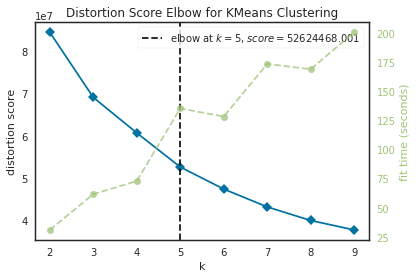

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
visualizer = KElbowVisualizer(kmeans_model, k=(2,10))
visualizer.fit(train_data)
visualizer.show()

## Score Model

In [8]:
best_n_clusters = 5
kmeans_model = KMeans(
    n_clusters=best_n_clusters, 
    random_state=random_state,
    n_jobs=n_jobs,
    verbose=0
)
kmeans_model.fit(train_data)
kmeans_model.score(train_data)

/home/ian/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


-52624707.66292042

## Predict

In [9]:
train_data = pd.DataFrame(train_data, columns=num_features)
train_data["cluster"] = kmeans_model.predict(train_data)

In [10]:
train_data.head()

,x_bin,y_bin,endzone_prox,s,a,dis,cluster
0,1.214645,0.230509,1.298915,-1.117803,-1.235960,-0.987551,2
1,1.214645,0.706536,1.183263,-1.114302,-1.235960,-1.020129,2
2,1.214645,1.658590,1.283440,-1.110801,-1.223469,-1.020129,2
3,1.214645,-0.245518,1.078199,-1.086296,-0.979899,-1.020129,2
4,1.214645,0.706536,1.260228,-1.117803,-1.242205,-1.052706,2


## Inspect Clusters

Let's take a look at the average values for each cluster to get an idea of the characteristics that separate them. 

In [11]:
by_cluster = train_data.groupby("cluster").mean()
#abs_scaler = MaxAbsScaler()
#by_cluster[num_features] = abs_scaler.fit_transform(by_cluster[num_features])

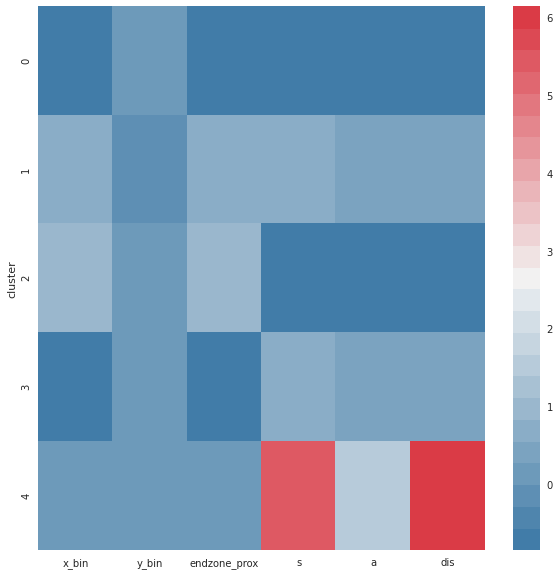

In [12]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(by_cluster, cmap=sns.diverging_palette(240, 10, n=25))
plt.show()

We can see here that there isn't much differentiation between most of the clusters. The one that really stands out is cluster 4. Here we average the highest s and dis values. These are most likely movements that resulted in the greatest change on the field. We could potentially benefit from looking at movements in this cluster differently than the other clusters in the overall model.

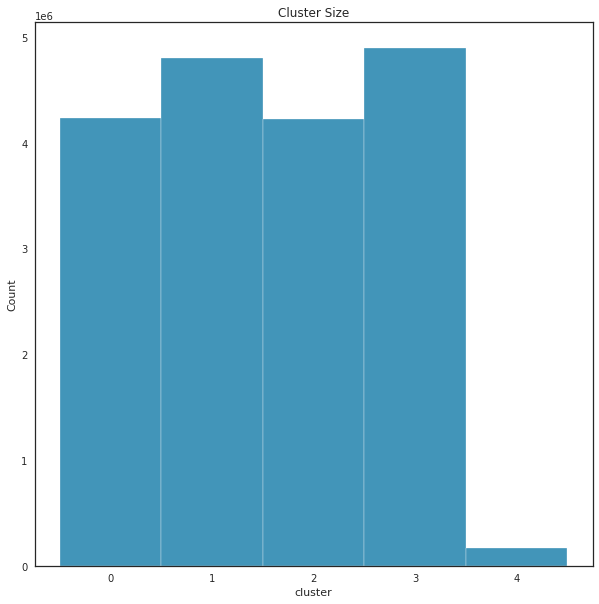

In [27]:
fig = plt.figure(figsize=(10,10))
ax = sns.histplot(train_data["cluster"], bins=best_n_clusters, discrete=True)
ax.set_title("Cluster Size")
plt.show()

As we can see here, cluster 4 is significantly smaller than the rest of the clusters. This is also the cluster that contains tracking data with the highest average s and dis values. It may be worth marking these or treating these points differently in the overall model. 